# **GR5242 HW04 Problem 5: Transfer learning with MobileNets**



**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**

There are many examples of external links to documentation. If you see reference to a `pytorch` or similar object, try hovering over the word to see if documentation is linked.

## Description:
In this homework, you will practice (1) going over the full procedure of training a neural network and (2) extending your knowledge on TF2, by implementing a transfer learning task. You will incorporate the existing [MobileNets](https://arxiv.org/abs/1704.04861) to your own network structure and to classify some new categories of images. Building and fitting the network from scratch is expensive and beyond the scope of this assignment, so you will load the MobileNets model which was pre-trained on the imagenet dataset. The version of MobileNet we're using is V2, which is a family of neural network architectures for efficient on-device image classification and related tasks.

As a general advice, you can refer to the official documentations for more info if necessary.



**Import modules for later usage.**

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import tqdm

import matplotlib.pyplot as plt
import numpy as np


print("PyTorch version: ",torch.__version__)

PyTorch version:  2.5.1+cu124


In [3]:
torch.cuda.device_count()

1

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("GPU is available.")
else:
    device = torch.device('cpu')
    print("GPU is not available.")

GPU is available.


## **Question 1: Download and format the data**

The data we are going to use is the [Oxford flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) which consists of 102 categories of flowers. Each class consists of between 40 and 258 images. The images can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The main difficulty of learninig from this dataset is in the large size of the classes. You may refer to [this paper](http://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) for what other researchers have done with it.

### (1) Data Pre-processing

First, load the  dataset from Kaggle (https://www.kaggle.com/competitions/oxford-102-flower-pytorch/data) where you can click "Download All" for the flower data. You can also download it directly from the zip file provided.

Then you split the data into training and testing sets. How many training and testing samples do you have?

During the pre-processing stage, we would like to format all the images for the MobileNet module.

For this module, the size of the input image is fixed to height x width = 224 x 224 pixels. The input images are expected to have 3 RGB color values in the range [0, 1], following the common image input conventions (analogously to TF 1.x).

In [5]:
# Initialize some parameters
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Define data transformations
transform = transforms.Compose([
    #do not restrain dim1 == dim2 == 224 here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #Custom transform to permute the dimensions
    #data is (3, dim1, dim2), we want (dim1, dim2, 3)
    #transforms.Lambda(lambda x: x.permute(1, 2, 0))
])

#Use validation set(contains labels) as a substitute for test,
#as test set under Kaggle is hidden for submission to compete for highest accuracy


# Assuming you have PyTorch datasets, replace root=' ' with your local directory.

########## Your code here ##########
from torchvision.datasets import Flowers102

# Load the dataset
# uses the built-in datase from torch, similar to that in tf
raw_train = Flowers102(root='./data', split="train", download=True)
raw_test = Flowers102(root='./data', split="test", download=True)

In [6]:
#-----------------------------------------------------------
# this part is not necessary
#for nn built-in flowers


#(note that the size of the dataset does match the tf dataset)

#raw_train
print(len(raw_train))
print(len(raw_test))

# Access a specific data point (e.g., the 10th data point)
index = 10  # Change this to the index you want to access
sample_image, label = raw_train[index]

# Display the label and other information
print("nn raw data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.size}")

# Apply the raw data transforms to raw_train and raw_test
train_nn = Flowers102(root='./data', split="train", download=True, transform=transform)
test_nn = Flowers102(root='./data', split="test", download=True, transform=transform)

#for nn build-in flowers: raw_train
print(len(train_nn))
print(len(test_nn))

sample_image, label = train_nn[100]
# Display the label and other information
print("nn standardized image data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.shape}")

1020
6149
nn raw data
Data at index 10:
Label: 1
Image shape: (500, 682)
1020
6149
nn standardized image data
Data at index 10:
Label: 10
Image shape: torch.Size([3, 224, 224])


### (2) Data Exploration

Let's plot some of the data.

In [7]:
from torch.utils.data import DataLoader, Dataset
assert isinstance(train_nn, Dataset)
assert isinstance(test_nn, Dataset)

# Print the datasets
print(train_nn)
print(test_nn)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 6149
    Root location: ./data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
# for i in range(5):  # Take example image 0,100,200,300,400
#     index = i*100
#     curr_f = train_nn[index][0]

#     #reshape each data form (3, 224, 224) to (224, 224, 3) to plot img correctly
#     reshaped_curr_f = curr_f.permute(1, 2, 0)

#     curr_lab = train_nn[index][1]
#     plt.title("Label: %d" % curr_lab)
#     plt.imshow(reshaped_curr_f)
#     plt.pause(0.5)

In [7]:
train_nn[616][0].shape

torch.Size([3, 224, 224])

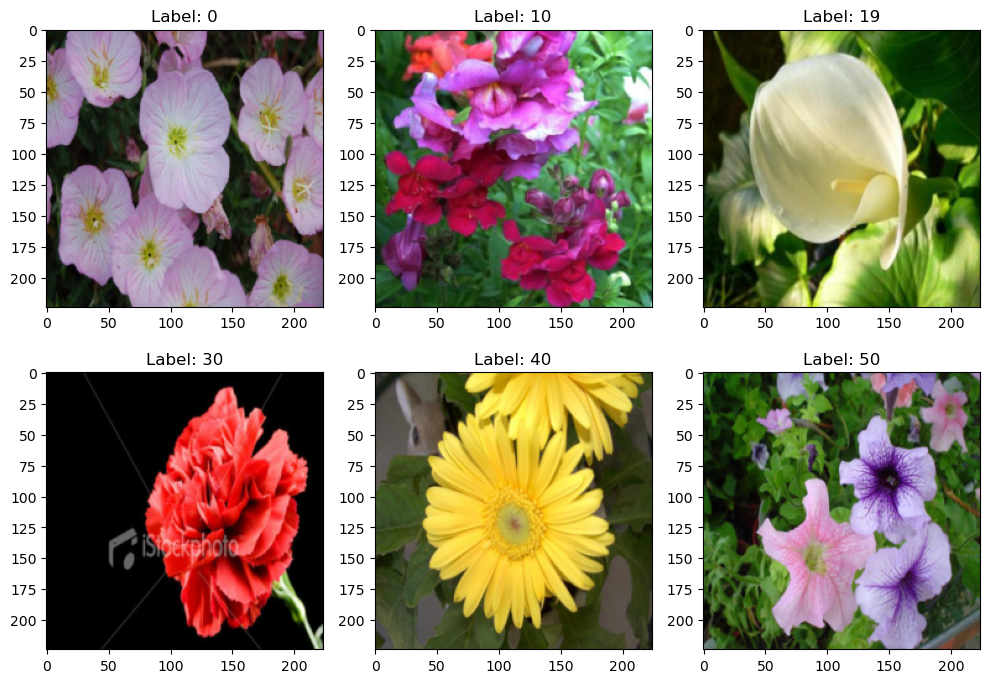

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # 2 rows, 3 columns

for i in range(6):  # Take example image 0, 100, 200, 300, 400
    index = i * 100
    curr_f = train_nn[index][0]

    # Reshape each data from (3, 224, 224) to (224, 224, 3)
    reshaped_curr_f = curr_f.permute(1, 2, 0)

    curr_lab = train_nn[index][1]

    row = i // 3
    col = i % 3

    axes[row, col].set_title("Label: %d" % curr_lab)
    axes[row, col].imshow(reshaped_curr_f)
    # axes[row, col].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### **Reflection Question (1a):**
In the data exploration stage, what is the purpose of "***assert isinstance(train, Dataset)***"?


**Your Answer:**
To verify that the `train_nn` and `test_nn` objects are `torch.utils.data.Dataset` instances since `torch.utils.data.DataLoader` only accepts `Dataset` class objects as inputs.

## **Part 2: Self-defined CNN**

In this section, you will define your own CNN (convolutional neural network) to classify the Oxford flowers.

Recall from the first problem, to build a neural network using `torch`, we build a class that carries out the functions of the model, define an optimizer, and iterate through a few key steps.

Here, we can make use of [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to save us a little hassle, now that we have seen how to build from the ground up in problem 1.

### Instructions

One suggestion is that you build a model with the following architecture, although you are free to try others as well with the same idea:

1.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d) with `kernel_size` 2 and `stride` 2

2.) Repeat step 1 (or a couple times), being careful about input shape

3.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten)

4.) Fully connected layer using [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear) and [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU)

5.)[`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout)

6.) Linear layer returning us to number of classes (102)

7.) [`nothing`] or [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax) to get label likelihood. Remember now that depending on which of these you use, you will need either [`criterion = nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss) or [`criterion = nn.NLLLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss) in training. If you use `nn.CrossEntropyLoss()`, you will need the extra step of calling [`nn.functional.softmax(output, dim=1)`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax) to compare outputs to targets in model evaluation, but not before calculating the loss in your training loop.

After fitting the model, please test the accuracy of the prediction on the test set.

In this stage, we do not ask for a great performance (you should have 'some' predictive performance though). But please ensure that you obtain a trainable model with no programming bugs. You may find it helpful to print the training progress bar or epoch.

In [58]:
# Step 1: Model definition
# Use a nn.Sequential model for deining your own CNN

########## Your code here ##########
# Define the model using nn.Sequential, naming it model
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1), # (3,244,244) -> (64,224,224)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # -> (64,112,112)
    
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # -> (128,112,112)
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # -> (128,56,56) (128,112,112)
    
	nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (256,112,112)
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256,112,112)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # (256,28,28)
    
	nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # (512,28,28)
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512,28,28)
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # (512,7,7)
    
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 102)
)

model = model.to(device)

In [59]:
# Optional: print a summary of your model
from torchsummary import summary

# Assuming your model_transfer is defined, you can print the summary
# if torch.cuda.is_available():
#     model = model.cuda() 

summary(model, (3, 224, 224))  # Assuming input size is (3, 224, 224)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
             ReLU-13          [-1, 256, 56, 56]               0
        MaxPool2d-14          [-1, 256,

### Instructions:

Here we will prepare ourselves for training.

We need to define a few things before running our training loop, namely the `DataLoader`, `criterion`, [`optimizer`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), and [`lr_scheduler`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html).

In [60]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(512, eps=1e-05, momentum=0.

In [61]:
# Step 2: Model compilation
# Be sure to specify the optimizer, loss and metric as required


# Assuming you have a PyTorch model named 'model'
train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)

# Define your loss function, naming it 'criterion'
########## Your code here ##########
criterion = nn.CrossEntropyLoss()

# Define your optimizer, 'optimizer' (Adam is suggested)
########## Your code here ##########
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler, 'lr_scheduler' (StepLR is suggested)
########## Your code here ##########
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95) #


### Instructions:

Fill in necessary blanks in the training loop, with the provided guidance

In [62]:
# Step 3: Model fitting
# Use the prepared training data to fit your CN
# Training loop
n_epochs = 15  # Set the number of training epochs
# Total number of data points in the dataset (number of points per epoch)
n_train = len(train_loader_nn.dataset)

print("start to train")
for epoch in range(n_epochs):
	model.train()
	total_accuracy = 0.0
	total_loss = 0.0

	loop = tqdm.tqdm(train_loader_nn, leave=True)
	for inputs, labels in loop:
	# for batch in train_loader_nn:
	# 	inputs, labels = batch
		# zero the gradient, calculate outputs, calculate loss,
		# backpropagate, and take a step
		# this should be familiar from earlier problems in the assignment
		########## YOUR CODE HERE ###########
		inputs = inputs.to(device)
		labels = labels.to(device)
		
		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, labels)

		# Calculate accuracy for this batch
		# predicted_classes = outputs.argmax(dim=1)
		_, predicted_classes = torch.max(nn.functional.softmax(outputs, dim=1), 1)
		batch_accuracy = (predicted_classes == labels).float().sum()
		total_accuracy += batch_accuracy.item()
		total_loss += loss.item() * len(labels)

		loss.backward()
		optimizer.step()

		loop.set_description(f"Epoch [{epoch+1}/{n_epochs}]")
		loop.set_postfix(loss=loss.item())


    # Calculate the average accuracy for the entire epoch
	average_accuracy = total_accuracy / n_train
	average_loss = total_loss / n_train
	# Take a step in learning rate with 'lr_scheduler`
	############# YOUR CODE HERE ############### Adjust learning rate
	scheduler.step()

	print(f" Epoch {epoch + 1}/{n_epochs}, Loss: {average_loss:.3f}, Accuracy: {average_accuracy * 100:.2f}%")
	#print("len train_loader is " + str(len(train_loader_nn)))


start to train


Epoch [1/15]: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s, loss=5.28]


 Epoch 1/15, Loss: 5.028, Accuracy: 3.04%


Epoch [2/15]: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s, loss=4.44]


 Epoch 2/15, Loss: 4.238, Accuracy: 5.98%


Epoch [3/15]: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s, loss=4.46]


 Epoch 3/15, Loss: 3.960, Accuracy: 9.22%


Epoch [4/15]: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s, loss=3.78]


 Epoch 4/15, Loss: 3.620, Accuracy: 12.45%


Epoch [5/15]: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s, loss=3.32]


 Epoch 5/15, Loss: 3.516, Accuracy: 14.90%


Epoch [6/15]: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s, loss=3.35]


 Epoch 6/15, Loss: 3.358, Accuracy: 18.04%


Epoch [7/15]: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s, loss=3.81]


 Epoch 7/15, Loss: 3.215, Accuracy: 19.61%


Epoch [8/15]: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s, loss=3.43]


 Epoch 8/15, Loss: 3.039, Accuracy: 21.47%


Epoch [9/15]: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s, loss=2.75]


 Epoch 9/15, Loss: 2.959, Accuracy: 23.33%


Epoch [10/15]: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s, loss=2.57]


 Epoch 10/15, Loss: 2.785, Accuracy: 28.53%


Epoch [11/15]: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s, loss=3.23]


 Epoch 11/15, Loss: 2.679, Accuracy: 29.22%


Epoch [12/15]: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s, loss=2.44]


 Epoch 12/15, Loss: 2.605, Accuracy: 30.39%


Epoch [13/15]: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s, loss=2.65]


 Epoch 13/15, Loss: 2.495, Accuracy: 33.24%


Epoch [14/15]: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s, loss=3.09]


 Epoch 14/15, Loss: 2.372, Accuracy: 33.92%


Epoch [15/15]: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s, loss=2.66]

 Epoch 15/15, Loss: 2.334, Accuracy: 35.69%


In [63]:
# Step 4: Model evaluation
test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)
n_test = len(test_dataloader_nn.dataset)  # Total number of test data points

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation during evaluation
	test_total_accuracy = 0.0
	test_total_loss = 0.0

	# Iterate through the test dataset
	for test_batch in test_dataloader_nn:
		test_inputs, test_labels = test_batch
		if torch.cuda.is_available():
			test_inputs = test_inputs.cuda()
			test_labels = test_labels.cuda()

		# Forward pass
		test_outputs = model(test_inputs)

		# Calculate the loss for the current batch
		test_loss = criterion(test_outputs, test_labels)

		# Accumulate the total loss (convert average loss to sum)
		test_total_loss += test_loss.item() * len(test_labels)

		# Calculate the accuracy for the current batch
		test_predicted_classes = test_outputs.argmax(dim=1)
		test_batch_accuracy = (test_predicted_classes == test_labels).float().sum()
		test_total_accuracy += test_batch_accuracy

	# Compute the average accuracy over the entire test set
	test_average_accuracy = test_total_accuracy / n_test

	# Compute the average loss over the entire test set
	test_average_loss = test_total_loss / n_test

	# Print results
	print(f"Test Loss: {test_average_loss:.4f}   Test Accuracy: {test_average_accuracy.item() * 100:.2f}%")


Test Loss: 3.0835   Test Accuracy: 26.62%


### **Reflection Questions 2a:**

**(1) How did you choose your network structure?**

I created the network structure based on the VGG architecture from lecture. VGG allows for deeper nets with relatively few parameters because of its smaller filters. Particularly, I noticed that adding Batch Normalization improves the performance by a lot. Before normalizing the batches, the training accuracy stayed below 5%.

**(2) Which optimizer did you use? Why?**

I chose Adam as hinted in the coding part. Adam calculates learning rates for each parameter, allowing the optimizer to adjust steps more effectively, especially in complex loss landscapes.

## **Part 3: Transfer Learning Using Pre-trained Model**

There are several types of transfer learning, as illustrated [here](http://ronny.rest/blog/post_2017_10_13_tf_transfer_learning/). In this homework, you will practice B2, using MobileNet_V2.

### (1) Freeze the pre-trained model and fine-tune the transfer learning.

In [8]:
import torchvision

# Load the pre-trained MobileNetV2 model
MobileNetV2 = torchvision.models.mobilenet_v2(pretrained=True)
MobileNetV2.classifier = nn.Identity()  # Remove the classifier layers

# Set the model to evaluation mode
MobileNetV2.eval()

C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Now you can go through the same steps to build and train the transfer learning model.

### Instructions:
Within the `model_transfer = nn.Sequential()` call, dd an Adaptive Average Pooling layer with [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d), then perform flattening and apply a linear layer as you should be familiar with from earlier.

As before, remember your choice of whether to use Cross Entropy or Negative Log Likelihood, and make sure to use the corresponding output of your model (i.e., whether to apply Softmax after calculating loss or within the model)

In [10]:
from torchsummary import summary
MobileNetV2 = MobileNetV2.to(device)
summary(MobileNetV2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [11]:
# Step 1: Model definition
# Use a torch.nn Sequential model for defining the transfer learning model (B1 style)

# Set MobileNetV2 parameters to non-trainable
for param in MobileNetV2.parameters():
    param.requires_grad = False

# Use a custom reshape layer
class ReshapeLayer(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1), 1, 1)

# Create a Sequential model in PyTorch
model_transfer = nn.Sequential(
    MobileNetV2, # (1280,)
    ReshapeLayer(),  # Reshape to [batch_size, num_channels, 1, 1]

########## Your code here ##########

	nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(1280, 102),
    nn.LogSoftmax(dim=1)
)

model_transfer = model_transfer.to(device)

In [41]:
from torchsummary import summary
summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [42]:
model_transfer

Sequential(
  (0): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

In [43]:
# define batch size here
batch_size = 32
input_tensor = torch.randn([batch_size, 3, 224, 224])

# visualize the model graphical structure
#Iterate through the model and print the dimensions at each layer
for layer in model_transfer:
    input_tensor = input_tensor.to(device)
    input_tensor = layer(input_tensor)
    print(f"Layer: {layer.__class__.__name__}, Output Shape: {input_tensor.shape}")

Layer: MobileNetV2, Output Shape: torch.Size([32, 1280])
Layer: ReshapeLayer, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: AdaptiveAvgPool2d, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: Flatten, Output Shape: torch.Size([32, 1280])
Layer: Linear, Output Shape: torch.Size([32, 102])
Layer: LogSoftmax, Output Shape: torch.Size([32, 102])


In [ ]:
#print(model_transfer)

### Instructions:

As before, write code to define your `optimizer`, `DataLoader`, `loss (criterion)`, and `lr_scheduler`.

Then, write a training loop.

Your code here should look similar to earlier in the assignment, outside of choosing hyperparameters, names, and possibly choice of loss.

In [48]:
# Step 2: Prepare for training
# Be sure to specify the optimizer, loss, DataLoader, lr_scheduler as before

########## Your code here ##########

train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model_transfer[-2].parameters(), lr=5*1e-4) # index for last Linear layer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Training loop
n_epochs = 10

# Step 3: Model fitting
# Use the prepared training data to fit the transfer learning model

########## Your code here ##########

n_train = len(train_loader_nn.dataset)

print("start to train")
for epoch in range(n_epochs):
	model_transfer.train()
	total_accuracy = 0.0
	total_loss = 0.0

	loop = tqdm.tqdm(train_loader_nn, leave=True)
	for inputs, labels in loop:
		inputs = inputs.to(device)
		labels = labels.to(device)
		
		optimizer.zero_grad()
		outputs = model_transfer(inputs)
		loss = criterion(outputs, labels)

		loss.backward()
		optimizer.step()

		predicted_classes = outputs.argmax(dim=1)
		# _, predicted_classes = torch.max(nn.functional.softmax(outputs, dim=1), 1)
		batch_accuracy = (predicted_classes == labels).float().sum()
		total_accuracy += batch_accuracy.item()
		total_loss += loss.item() * len(labels)

		loop.set_description(f"Epoch [{epoch+1}/{n_epochs}]")
		loop.set_postfix(loss=loss.item())


	average_accuracy = total_accuracy / n_train
	average_loss = total_loss / n_train

	scheduler.step()

	print(f" Epoch {epoch + 1}/{n_epochs}, Loss: {average_loss:.3f}, Accuracy: {average_accuracy * 100:.2f}%")
	#print("len train_loader is " + str(len(train_loader_nn)))


start to train


Epoch [1/10]: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s, loss=3.94]


 Epoch 1/10, Loss: 4.486, Accuracy: 7.55%


Epoch [2/10]: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s, loss=2.79]


 Epoch 2/10, Loss: 3.226, Accuracy: 58.43%


Epoch [3/10]: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s, loss=2]   


 Epoch 3/10, Loss: 2.345, Accuracy: 81.47%


Epoch [4/10]: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s, loss=1.52]


 Epoch 4/10, Loss: 1.706, Accuracy: 90.29%


Epoch [5/10]: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s, loss=1.26]


 Epoch 5/10, Loss: 1.265, Accuracy: 95.20%


Epoch [6/10]: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s, loss=1.16] 


 Epoch 6/10, Loss: 0.954, Accuracy: 96.67%


Epoch [7/10]: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s, loss=0.679]


 Epoch 7/10, Loss: 0.735, Accuracy: 98.43%


Epoch [8/10]: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s, loss=0.504]


 Epoch 8/10, Loss: 0.591, Accuracy: 99.31%


Epoch [9/10]: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s, loss=0.687]


 Epoch 9/10, Loss: 0.493, Accuracy: 99.51%


Epoch [10/10]: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s, loss=0.433]

 Epoch 10/10, Loss: 0.399, Accuracy: 99.41%


In [49]:
# Step 3: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)
n_test = len(test_dataloader_nn.dataset)

print("model_transfer")
model_transfer.eval()  # Set the model to evaluation mode
with torch.no_grad():

    test_total_accuracy = 0.0
    test_total_loss = 0.0  # Reset total loss at the beginning of each epoch

    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model_transfer(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        # Accumulate the total loss (convert average loss to sum)
        test_total_loss += test_loss.item() * len(test_labels)
        _, test_predicted = torch.max(test_outputs, 1)  # Get the predicted class
        test_batch_accuracy = (test_predicted == test_labels).float().sum()
        test_total_accuracy += test_batch_accuracy.item()


    # Compute the average accuracy over the entire test set
    test_average_accuracy = test_total_accuracy / n_test

    # Compute the average loss over the entire test set
    test_average_loss = test_total_loss / n_test

    # Print results
    print(f"Test Loss: {test_average_loss:.3f}   Test Accuracy: {test_average_accuracy * 100:.2f}%")

model_transfer
Test Loss: 1.090   Test Accuracy: 83.23%


### (2) Fine-tune some parameters in your network to see if you can improve the performance on testing data. (Optional)

In [13]:
import matplotlib.pyplot as plt

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm

def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs, device):
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_accuracy = 0.0
        total_loss = 0.0
        
        loop = tqdm.tqdm(train_loader, leave=True)
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            predicted_classes = outputs.argmax(dim=1)
            batch_accuracy = (predicted_classes == labels).float().sum()
            total_accuracy += batch_accuracy.item()
            total_loss += loss.item() * len(labels)

            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        # Calculate and store training accuracy for the epoch
        epoch_accuracy = total_accuracy / len(train_loader.dataset)
        train_accuracies.append(epoch_accuracy) 
        
        scheduler.step()


    model.eval()
    with torch.no_grad():
        test_accuracy = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted_classes = outputs.argmax(dim=1)
            test_accuracy += (predicted_classes == labels).float().sum().item()
        test_accuracy /= len(test_loader.dataset)

    return train_accuracies, test_accuracy

In [ ]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
batch_sizes = [8, 16, 32, 64]

best_accuracy = 0
best_params = {}
all_results = {}

In [44]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_loader = DataLoader(train_nn, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_nn, batch_size=batch_size)

        # Re-initialize the model
        model_transfer = nn.Sequential(
            MobileNetV2,
            ReshapeLayer(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, 102),
            nn.LogSoftmax(dim=1)
        )
        model_transfer = model_transfer.to(device)

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model_transfer[-2].parameters(), lr=lr)  # Optimize the Linear layer
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

        # Train and evaluate the model
        epochs = 10
        results = train_and_evaluate_model(model_transfer, train_loader, test_loader, criterion, optimizer, scheduler, epochs, device)
        all_results[(lr, batch_size)] = results

Epoch [10/10]: 100%|██████████| 128/128 [00:12<00:00, 10.52it/s, loss=6.77]    


In [45]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
batch_sizes = [8, 16, 32, 64]

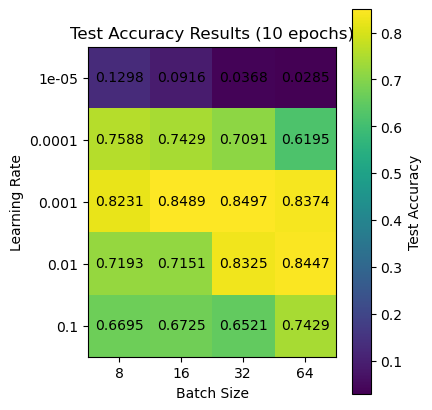

In [46]:
accuracy_matrix = np.zeros((len(learning_rates), len(batch_sizes)))
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        accuracy_matrix[i, j] = all_results[(lr, batch_size)][1]

# Create the heatmap
plt.figure(figsize=(4, 5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Test Accuracy')

plt.xticks(np.arange(len(batch_sizes)), batch_sizes)
plt.yticks(np.arange(len(learning_rates)), learning_rates)
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.title('Test Accuracy Results (10 epochs)')

for i in range(len(learning_rates)):
    for j in range(len(batch_sizes)):
        text = plt.text(j, i, f'{accuracy_matrix[i, j]:.4f}', ha='center', va='center')

C:\Users\Austin\AppData\Local\Temp\ipykernel_20428\302394820.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(learning_rates))  # Get a colormap with distinct colors


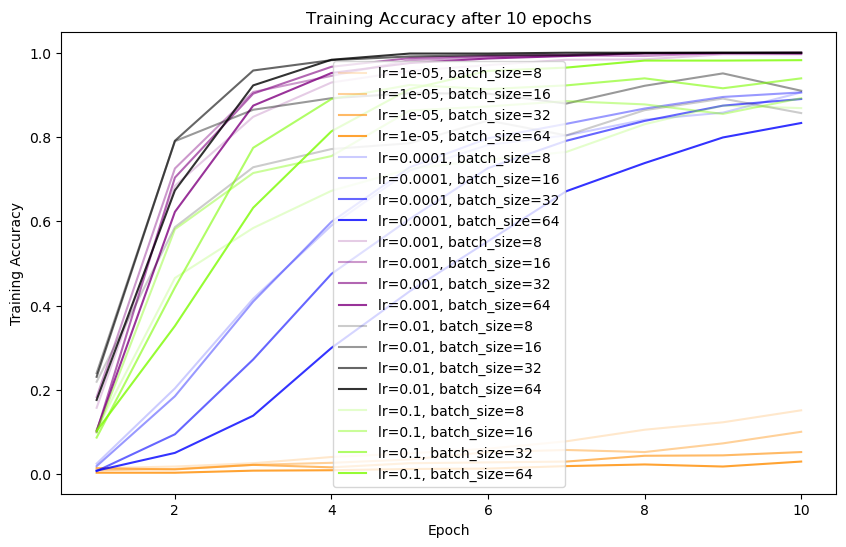

In [55]:
plt.figure(figsize=(10, 6))

color_map = plt.cm.get_cmap('viridis', len(learning_rates))  # Get a colormap with distinct colors

colors = ['darkorange', 'blue', 'purple', 'black', 'lawngreen']

for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        train_epoch_acc = all_results[(lr, batch_size)][0]
        plt.plot(range(1, epochs + 1), train_epoch_acc, 
                 label=f'lr={lr}, batch_size={batch_size}', 
                #  color=color_map(i),  # Use color based on learning rate
                 color = colors[i],
                 alpha=(1+j) / (1+len(batch_sizes)))  # Add alpha gradient for batch size

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy after $10$ epochs')
plt.legend()
plt.show()

### **Reflection Questions 3a:**

(1) Briefly explain the network structure of MobileNet and how is it different from other models? \
(2) In your experiment, which parameter(s) is the network most sensitive to? Can you briefly reason why? \
(3) What are some pros and cons of doing transfer learning? \
(4) What is a batch? How does the batch size affect the training process? \
(5) What is an epoch during the training process?

**Your Answer:**




1. MobileNet differs from a traditional CNN by that it has depthwise-separable convolution:
	- Depthwise convolutions (having separate convolution for each channel) to reduce computation and
	- Pointwise convolutions (regular convolution with 1x1 filter) to regain the traditional convultion receptive field (information passing from different channels).
	- reference: https://www.youtube.com/watch?v=vVaRhZXovbw

2. The network is likely the most sensitive to the learning rate. We are fine-tuning a pre-trained model and the weights of the pre-trained layers are likely well-suited for general purposes. If the learning rate is too high, we may disrupt the pre-trained weights, leading to poor performance.

3. Transfer Learning Pros vs Cons
	- Pros: faster training; can achieve good results with relatively small datasets.
	- Cons: overfitting if the pre-trained model is very different from the target task

4. A batch is a subset of data used to update the model's weights in one iteration. The larger a batch is, the more computation is required but we may also expect stabler training results.

5. An epoch is one complete pass on the entire dataset. During each epoch, the model sees training data in batches and updates its weights.

(6) Describe any observation you find interesting from the above experiment (Open-ended).

**Your Answer:**




The choice of optimizer and scheduler seems to heavily influence the model performance, and there doesn't seem to be one standardized methodology on choosing the best hyperparameters.